In [1]:
# to add the spiking model codebase to the path
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

In [3]:
class MidpointNormalize(colors.Normalize):
    ''' create asymmetric norm '''

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def generate_adjacency_matrix_within(nUnits, pConn, allowAutapses=False):
    
    # pre is row, post is column
    
    bestNumberOfSynapses = int(np.round(pConn * nUnits ** 2))
    
    if allowAutapses:
        indicesFlat = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False)
        adjMat = np.zeros((nUnits, nUnits), dtype=bool)
        adjMat[np.unravel_index(indicesFlat, (nUnits, nUnits))] = True
    else:
        probabilityArray = np.full((nUnits, nUnits), 1 / (nUnits * (nUnits - 1)))
        probabilityArray[np.diag_indices_from(probabilityArray)] = 0
        indicesFlat = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False, p=probabilityArray.ravel())
        adjMat = np.zeros((nUnits, nUnits), dtype=bool)
        adjMat[np.unravel_index(indicesFlat, (nUnits, nUnits))] = True
        
    return adjMat

def generate_adjacency_matrix_between(nUnitsPre, nUnitsPost, pConn):
    
    # pre is row, post is column
    
    bestNumberOfSynapses = int(np.round(pConn * nUnitsPre * nUnitsPost))
    indicesFlat = np.random.choice(nUnitsPre * nUnitsPost, bestNumberOfSynapses, replace=False)
    adjMat = np.zeros((nUnitsPre, nUnitsPost), dtype=bool)
    adjMat[np.unravel_index(indicesFlat, (nUnitsPre, nUnitsPost))] = True
    
    return adjMat

def w_from_a(a, mean, sd):
    """ given adjacency matrix a, generate weight matrix w
    from a random normal distribution with mean and sd.
    clip negative weights to be 0.
    """
    
    preInds, postInds = np.where(a)
    weights = np.random.normal(mean, sd, preInds.size)
    weights[weights < 0] = 0
    w = np.zeros_like(a, dtype=float)
    w[a] = weights
    return w

In [4]:
def weight_matrix(ax, values,
                       useCmap='RdBu_r', limsMethod='absmax',
                       xlabel='', ylabel='', clabel=''):
    """ given an axis handle, an array of values, and some optional params,
        visualize a weight matrix in a heat map using imshow
    """
    
    i = ax.imshow(values,
                  cmap=getattr(plt.cm, useCmap),
                  aspect='auto',
                  interpolation='none')
    ax.set(xlabel=xlabel, ylabel=ylabel)

    if limsMethod == 'absmax':
        vmax = np.max(np.fabs(values))
        vmin = -vmax
    elif limsMethod == 'minmax':
        vmax, vmin = np.max(values), np.min(values)

    if vmin != -vmax:
        norm = MidpointNormalize(vmin, vmax, 0)
    else:
        norm = False

    i.set_clim(vmin, vmax)
    if norm:
        i.set_norm(norm)

    cb = plt.colorbar(i, ax=ax)
    cb.ax.set_ylabel(clabel, rotation=270)    

In [5]:
# goal: plot results of a learning run: average firing rate and weight changes

In [6]:
from results import Results

INFO       Cache size for target "cython": 7159 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\mikejseay\.cython\brian_extensions" directory. [brian2]


In [ ]:
R.trialUpFRExc
R.trialUpFRInh
R.trialwEE
R.trialwEI
R.trialwIE
R.trialwII

In [67]:
targetPath = 'C:/Users/mikejseay/Documents/BrianResults/'

# targetFile = 'jercogDefaultP05_2021-04-18-18-58_results'  # cross-homeo
# targetFile = 'jercogDefaultP05_2021-04-18-21-36_results'  # balance
# targetFile = 'jercogDefaultP05_2021-04-18-23-01_results'  # test

# targetFile = 'destexheDefaultP02_2021-04-19-22-43_results'  # cross-homeo

targetFile = 'jercogDefaultP05_2021-04-19-00-31_results'

R = Results()
R.init_from_file(targetFile, targetPath)
R.p['useRule']

'cross-homeo'

(0, 20)

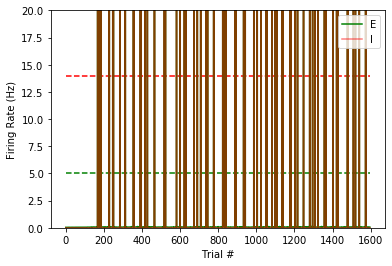

In [64]:
f, ax = plt.subplots()
ax.plot(R.trialUpFRExc, label='E', color='g')
ax.plot(R.trialUpFRInh, label='I', color='r', alpha=.5)
ax.legend()
ax.hlines(R.p['setUpFRExc'], 0, len(R.trialUpFRExc), ls='--', color='g')
ax.hlines(R.p['setUpFRInh'], 0, len(R.trialUpFRInh), ls='--', color='r')
ax.set_xlabel('Trial #')
ax.set_ylabel('Firing Rate (Hz)')
ax.set_ylim(0, 20)

In [65]:
print('wEE mult:', R.trialwEE[-1] / R.trialwEE[0])
print('wEI mult:', R.trialwEI[-1] / R.trialwEI[0])
print('wIE mult:', R.trialwIE[-1] / R.trialwIE[0])
print('wII mult:', R.trialwII[-1] / R.trialwII[0])

wEE mult: 1.5054381054667871
wEI mult: 0.8569118033085343
wIE mult: 2.30857808102427
wII mult: 0.9171040202096457


Text(0, 0.5, 'Weight (pA)')

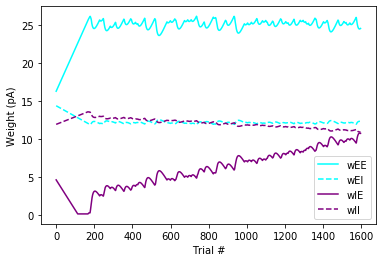

In [66]:
f, ax = plt.subplots()
ax.plot(R.trialwEE, label='wEE', color='cyan')
ax.plot(R.trialwEI, label='wEI', color='cyan', ls='--')
ax.plot(R.trialwIE, label='wIE', color='purple')
ax.plot(R.trialwII, label='wII', color='purple', ls='--')
ax.legend()
ax.set_xlabel('Trial #')
ax.set_ylabel('Weight (pA)')

In [71]:
testSpikeInds = np.array([0, 1, 5, 2, 1, 4]).astype(int)
test = np.bincount(testSpikeInds)
test2 = np.bincount(testSpikeInds, minlength = 7)

In [72]:
test

array([1, 2, 1, 0, 1, 1], dtype=int64)

In [73]:
test2

array([1, 2, 1, 0, 1, 1, 0], dtype=int64)

In [25]:
nUnits = 10
pConn = 1
allowAutapses = False

In [33]:
bestNumberOfSynapses = int(np.round(pConn * nUnits ** 2))
print(bestNumberOfSynapses)

if allowAutapses:
    indicesFlat = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False)
else:
    probabilityArray = np.full((nUnits, nUnits), 1 / (nUnits * (nUnits - 1)))
    probabilityArray[np.diag_indices_from(probabilityArray)] = 0
    
    if pConn > (nUnits - 1) / nUnits:
        bestNumberOfSynapses -= int(np.round(nUnits ** 2 * (pConn - (nUnits - 1) / nUnits)))
        print(bestNumberOfSynapses)
    
    indicesFlat = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False, p=probabilityArray.ravel())

preInds, postInds = np.unravel_index(indicesFlat, (nUnits, nUnits))

100
90


In [32]:
int(np.round(nUnits ** 2 * (pConn - (nUnits - 1) / nUnits)))

10

In [28]:
int(np.round(((1 - pConn) * nUnits ** 2)))

0

In [ ]:
bestNumbe

In [4]:
# goal 2: apply normally distributed weights

In [15]:
nExc = 8
nInh = 2
pConn = 0.25
randnMean = 1
randnSD = 0.2

aEE = generate_adjacency_matrix_within(nExc, pConn, allowAutapses=False)
aIE = generate_adjacency_matrix_between(nExc, nInh, pConn)
aEI = generate_adjacency_matrix_between(nInh, nExc, pConn)
aII = generate_adjacency_matrix_within(nInh, pConn, allowAutapses=False)

wEE = w_from_a(aEE, randnMean, randnSD)
wIE = w_from_a(aIE, randnMean, randnSD)
wEI = w_from_a(aEI, randnMean, randnSD)
wII = w_from_a(aII, randnMean, randnSD)

In [16]:
wEE

array([[0.        , 1.14111646, 0.        , 0.        , 0.91245524,
        0.        , 0.        , 0.58845372],
       [0.        , 0.        , 0.        , 0.6840502 , 0.        ,
        0.        , 0.85097995, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.10777655],
       [1.32835325, 0.        , 0.        , 0.        , 0.93841501,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.06376324, 0.        , 0.        ,
        1.08381029, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.1919193 , 0.        ,
        0.        , 0.        , 0.70794324],
       [0.        , 1.26854389, 0.        , 0.8659907 , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.80745652, 0.        ,
        0.        , 1.12804687, 0.        ]])

In [6]:
preInds, postInds = np.where(aEE)

In [7]:
preInds 

array([0, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 7, 7, 7], dtype=int64)

In [8]:
postInds

array([2, 0, 2, 4, 6, 4, 5, 1, 5, 5, 4, 6, 0, 0, 2, 4], dtype=int64)

In [11]:
weights = np.random.normal(size=preInds.size)

In [12]:
weights

array([ 0.54428341,  0.42842826, -0.1290585 , -1.68726729,  0.40761932,
       -0.48984529,  0.14953924,  0.58476359,  0.39997037,  1.15748391,
        0.325102  , -0.43593126, -1.13064903, -0.70461682,  1.49334686,
        0.0551257 ])

In [13]:
wEE[preInds, postInds] = weights

In [14]:
wEE

array([[ 0.        ,  0.        ,  0.54428341,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.42842826,  0.        , -0.1290585 ,  0.        , -1.68726729,
         0.        ,  0.40761932,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.48984529,
         0.14953924,  0.        ,  0.        ],
       [ 0.        ,  0.58476359,  0.        ,  0.        ,  0.        ,
         0.39997037,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.15748391,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.325102  ,
         0.        , -0.43593126,  0.        ],
       [-1.13064903,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.70461682,  0.        ,  1.49334686,  0.        ,  0.0551257 ,
         0.        ,  0.        ,  0.        ]])

In [6]:
wFull = np.block([[wEE, wIE],[-wEI, -wII]])

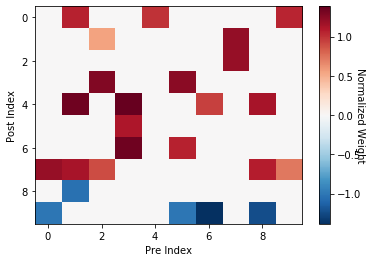

In [7]:
f, ax = plt.subplots()
weight_matrix(ax, wFull,
                   xlabel='Pre Index',
                   ylabel='Post Index',
                   clabel='Normalized Weight',)

In [174]:
f, ax = plt.subplots()
i = ax.imshow(wFull,
              cmap='RdBu_r',
              aspect='auto',
              interpolation='none', )
ax.set(xlabel='Post Index', ylabel='Pre Index')
cb = plt.colorbar(i, ax=ax)
cb.ax.set_ylabel('Normalized Weight', rotation=270)

Text(0, 0.5, 'Normalized Weight')

In [104]:
def method2():
    # more exact method
    nUnits = 10000
    pConn = 0.05
    allowAutapses = False

    bestNumberOfSynapses = int(np.round(pConn * nUnits ** 2))
    roughIndices = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False)
    adjMat = np.zeros((nUnits, nUnits), dtype=bool)
    adjMat[np.unravel_index(roughIndices, (nUnits, nUnits))] = True
    print(adjMat)
    traceRough = np.trace(adjMat)
    adjMat[np.diag_indices_from(adjMat)] = False
    nonDiagonalZeroBool = ~(np.eye(nUnits, dtype=bool) | adjMat)
    nonDiagonalIndicesFlattened = np.ravel_multi_index(np.where(nonDiagonalZeroBool), (nUnits, nUnits))
    newSynapseIndices = np.random.choice(nonDiagonalIndicesFlattened, traceRough, replace=False)
    adjMat[np.unravel_index(newSynapseIndices, (nUnits, nUnits))] = True

In [2]:
# goal 0: create a concise presentation of model parameters and compare two
# actually on second thought this doesn't really matter

importantParams = ['nUnits', 'propConnect', ]
from params import paramsJercog, paramsDestexhe
import pandas as pd
paramsJercog